# Patient Cohort & Journey Analytics

In [1]:
from snowflake.snowpark import Session
from snowflake.snowpark.version import VERSION

session = Session.builder.config("connection_name", "patient_journey").create()

In [2]:
snowflake_environment = session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION

# current environment details
print('\nConnection Established with the following parameters:')
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))


Connection Established with the following parameters:
User                        : BLUMENFELD
Role                        : "ACCOUNTADMIN"
Database                    : "PATIENT_DB"
Schema                      : "PUBLIC"
Warehouse                   : "ZACH_GDS_DEMO"
Snowflake version           : 8.44.1
Snowpark for Python version : 1.25.0


## Patient Statistics by Cohort

In [3]:
patient_cohorts_df = session.table(f'patient_db.public.patient_cohorts').to_pandas()
patient_cohorts_df

,COHORT,ID,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,MIDDLE,...,CITY,STATE,COUNTY,FIPS,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,INCOME
0,123,34176754-ac3a-8b57-4308-ca62a38443b8,1994-03-20,None,999-65-3631,S99938832,X46996685X,Mrs.,Marjory382,Exie255,...,Deerfield,Massachusetts,Franklin County,25011.0,1342,42.591988,-72.644525,462613.35,92618.12,63123
1,123,9edcca4d-eac7-0f5d-8a4a-965ac977d3ad,1992-12-03,None,999-86-4120,S99968734,X72422570X,Mrs.,Barrie587,Mario764,...,Revere,Massachusetts,Suffolk County,25025.0,2151,42.402749,-70.994531,129367.59,299401.25,92808
2,123,67e34bab-9b75-d5f9-f3bc-6a6f13c8ba47,1998-08-15,None,999-74-9644,S99958204,X43150011X,Ms.,Carry843,Bao544,...,Winthrop,Massachusetts,Suffolk County,25025.0,2128,42.314054,-71.035209,7307.41,254858.00,11242
3,123,44dfd919-a4e2-08d4-aeb4-2c41d4b4f2d1,2002-03-10,None,999-88-5956,S99973850,X61889183X,Ms.,Chastity705,Leonor133,...,Townsend,Massachusetts,Middlesex County,25017.0,1469,42.704757,-71.694710,58868.48,473339.04,183674
4,123,80b0dccc-6025-c21c-4a80-632c98cffbcc,1981-04-14,None,999-17-2619,S99915328,X8704589X,Mrs.,Felicidad691,Dione665,...,Grafton,Massachusetts,Worcester County,NaN,0,42.238986,-71.702373,436003.07,359340.25,82747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,16,c021e92e-a251-ea8a-cd36-b1d63212879c,1967-08-25,None,999-74-2189,S99926315,X35211253X,Ms.,Emilia403,María del Carmen27,...,Boston,Massachusetts,Suffolk County,25025.0,2120,42.292356,-71.102928,1130646.82,422244.57,44346
196,16,b078b69d-1a29-fd38-0312-3144b2a1eeb5,2003-09-01,None,999-71-3688,S99961697,X77892846X,Ms.,Annis955,Taryn906,...,Newton,Massachusetts,Middlesex County,25017.0,2464,42.339524,-71.178527,110979.81,587479.43,71731
197,16,db3a68f0-6825-4147-c594-84ca9364756b,1997-04-07,None,999-87-3319,S99921463,X66979809X,Ms.,Inocencia535,Margaret865,...,Boston,Massachusetts,Suffolk County,25025.0,2121,42.341063,-71.080945,136001.52,43841.24,722393
198,16,f5cd9ff8-b57c-bbe1-542a-10c11c5fec87,1961-11-30,2014-12-27,999-85-9073,S99988112,X33419968X,Ms.,Nicholle822,Christiane220,...,Springfield,Massachusetts,Hampden County,25013.0,1108,42.104842,-72.614749,20842.26,1097909.60,8601


In [6]:
print('Number of Patients Per Cohort')
session.sql(f'''
    SELECT COHORT, COUNT(*) AS CNT
    FROM PATIENT_DB.PUBLIC.PATIENT_COHORTS
    GROUP BY COHORT
    ORDER BY CNT DESC
''').to_pandas()

Number of Patients Per Cohort


,COHORT,CNT
0,22,51
1,123,50
2,43,30
3,57,22
4,44,20
5,16,16
6,33,11


In [4]:
from datetime import date

def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

patient_cohorts_df['COHORT'] = patient_cohorts_df['COHORT'].astype(str)
patient_cohorts_df['AGE'] = patient_cohorts_df['BIRTHDATE'].apply(calculate_age)

In [11]:
import plotly.express as px

#fig = px.box(patient_cohorts_df, x='COHORT', y='INCOME')
#fig.update_layout(title_text=f"Cohort Income Distributions", 
#        font_size=10, 
#        height=500
#)
#fig.show()

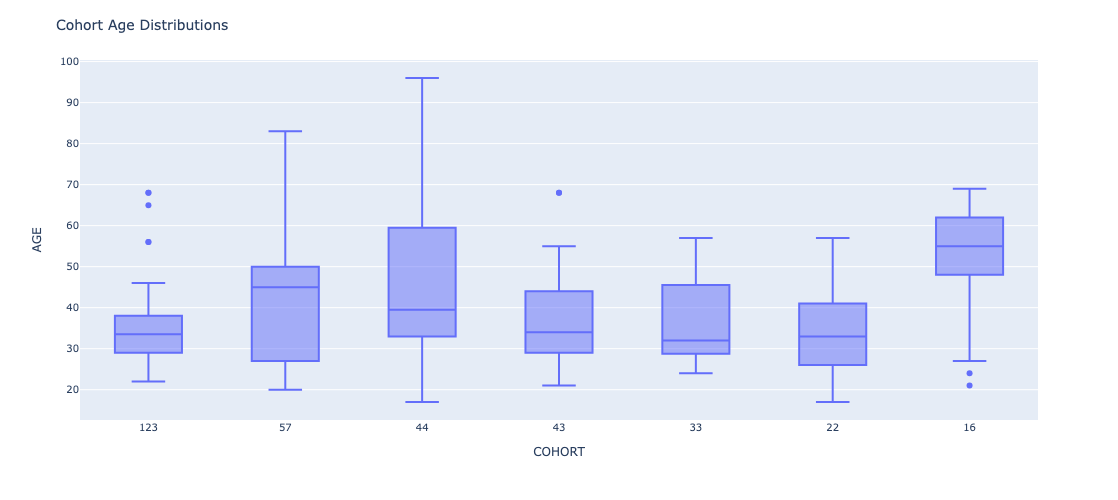

In [12]:
fig = px.box(patient_cohorts_df, x='COHORT', y='AGE')
fig.update_layout(title_text=f"Cohort Age Distributions", 
        font_size=10, 
        height=500
)
fig.show()

## Procedure & Encounter Statistics by Cohort
TODO

In [13]:
proc_cohorts_df = session.table(f'patient_db.public.procedure_cohorts').to_pandas()
proc_cohorts_df

,COHORT,START_TIME,STOP_TIME,PATIENT,ENCOUNTER,SYSTEM,CODE,DESCRIPTION,BASE_COST,REASONCODE,REASONDESCRIPTION
0,44,2015-06-19 05:03:41,2015-06-19 05:18:41,a0f3cc78-810a-3ec6-36cf-221b374350d6,3e3cd9ec-d27a-98ac-c4a4-51bc4420cb7b,http://snomed.info/sct,252160004,Standard pregnancy test (procedure),9046.75,72892002,Normal pregnancy (finding)
1,44,2015-06-19 05:03:41,2015-06-19 05:18:41,a0f3cc78-810a-3ec6-36cf-221b374350d6,3e3cd9ec-d27a-98ac-c4a4-51bc4420cb7b,http://snomed.info/sct,169230002,Ultrasound scan for fetal viability (procedure),4049.70,72892002,Normal pregnancy (finding)
2,44,2015-06-19 05:03:41,2015-06-19 05:18:41,a0f3cc78-810a-3ec6-36cf-221b374350d6,3e3cd9ec-d27a-98ac-c4a4-51bc4420cb7b,http://snomed.info/sct,44608003,Blood group typing (procedure),2283.31,72892002,Normal pregnancy (finding)
3,44,2015-06-19 05:03:41,2015-06-19 05:18:41,a0f3cc78-810a-3ec6-36cf-221b374350d6,3e3cd9ec-d27a-98ac-c4a4-51bc4420cb7b,http://snomed.info/sct,104091002,Hemogram automated with red blood cells whi...,1064.42,72892002,Normal pregnancy (finding)
4,44,2015-06-19 05:03:41,2015-06-19 05:18:41,a0f3cc78-810a-3ec6-36cf-221b374350d6,3e3cd9ec-d27a-98ac-c4a4-51bc4420cb7b,http://snomed.info/sct,47758006,Hepatitis B surface antigen measurement (proce...,3256.59,72892002,Normal pregnancy (finding)
...,...,...,...,...,...,...,...,...,...,...,...
9312,43,2000-12-14 06:00:31,2000-12-14 06:15:31,37c9a873-d7b8-b1ad-3f34-22eb52218432,bb674691-815c-312b-2bf6-042553aace4e,http://snomed.info/sct,399014008,Administration of vaccine product containing o...,1108.27,72892002,Normal pregnancy (finding)
9313,43,2000-12-14 06:00:31,2000-12-14 06:15:31,37c9a873-d7b8-b1ad-3f34-22eb52218432,bb674691-815c-312b-2bf6-042553aace4e,http://snomed.info/sct,268556000,Urine screening for glucose (procedure),862.80,72892002,Normal pregnancy (finding)
9314,43,2001-03-15 06:00:31,2001-03-15 06:15:31,37c9a873-d7b8-b1ad-3f34-22eb52218432,1c857117-7f2e-07b1-e3e1-4d522c54b24a,http://snomed.info/sct,118001005,Streptococcus pneumoniae group B antigen assay...,1441.51,72892002,Normal pregnancy (finding)
9315,43,2001-04-05 06:00:31,2001-04-05 06:15:31,37c9a873-d7b8-b1ad-3f34-22eb52218432,500fe2f0-f046-323b-18cf-ec56557afa54,http://snomed.info/sct,18946005,Epidural anesthesia (procedure),1294.99,72892002,Normal pregnancy (finding)


In [57]:
proc_cohort_agg_df = session.sql(f'''
    SELECT COHORT, CODE, DESCRIPTION, COUNT(*) AS CNT, RATIO_TO_REPORT(CNT) OVER (PARTITION BY COHORT) AS PERCENT_CNT
    FROM PATIENT_DB.PUBLIC.PROCEDURE_COHORTS
    GROUP BY COHORT, CODE, DESCRIPTION
    ORDER BY CNT DESC
''').to_pandas()
proc_cohort_agg_df['COHORT'] = proc_cohort_agg_df['COHORT'].astype(str)
proc_cohort_agg_df.loc[proc_cohort_agg_df.PERCENT_CNT < 0.035, 'DESCRIPTION'] = "OTHER"
proc_cohort_agg_df

,COHORT,CODE,DESCRIPTION,CNT,PERCENT_CNT
0,123,104091002,Hemogram automated with red blood cells whi...,219,0.061952
1,123,5880005,Physical examination procedure (procedure),196,0.055446
2,123,169230002,Ultrasound scan for fetal viability (procedure),192,0.054314
3,123,252160004,Standard pregnancy test (procedure),192,0.054314
4,22,104091002,Hemogram automated with red blood cells whi...,191,0.073745
...,...,...,...,...,...
175,33,18946005,OTHER,1,0.008621
176,33,118001005,OTHER,1,0.008621
177,44,236974004,OTHER,1,0.001391
178,22,367494004,OTHER,1,0.000386


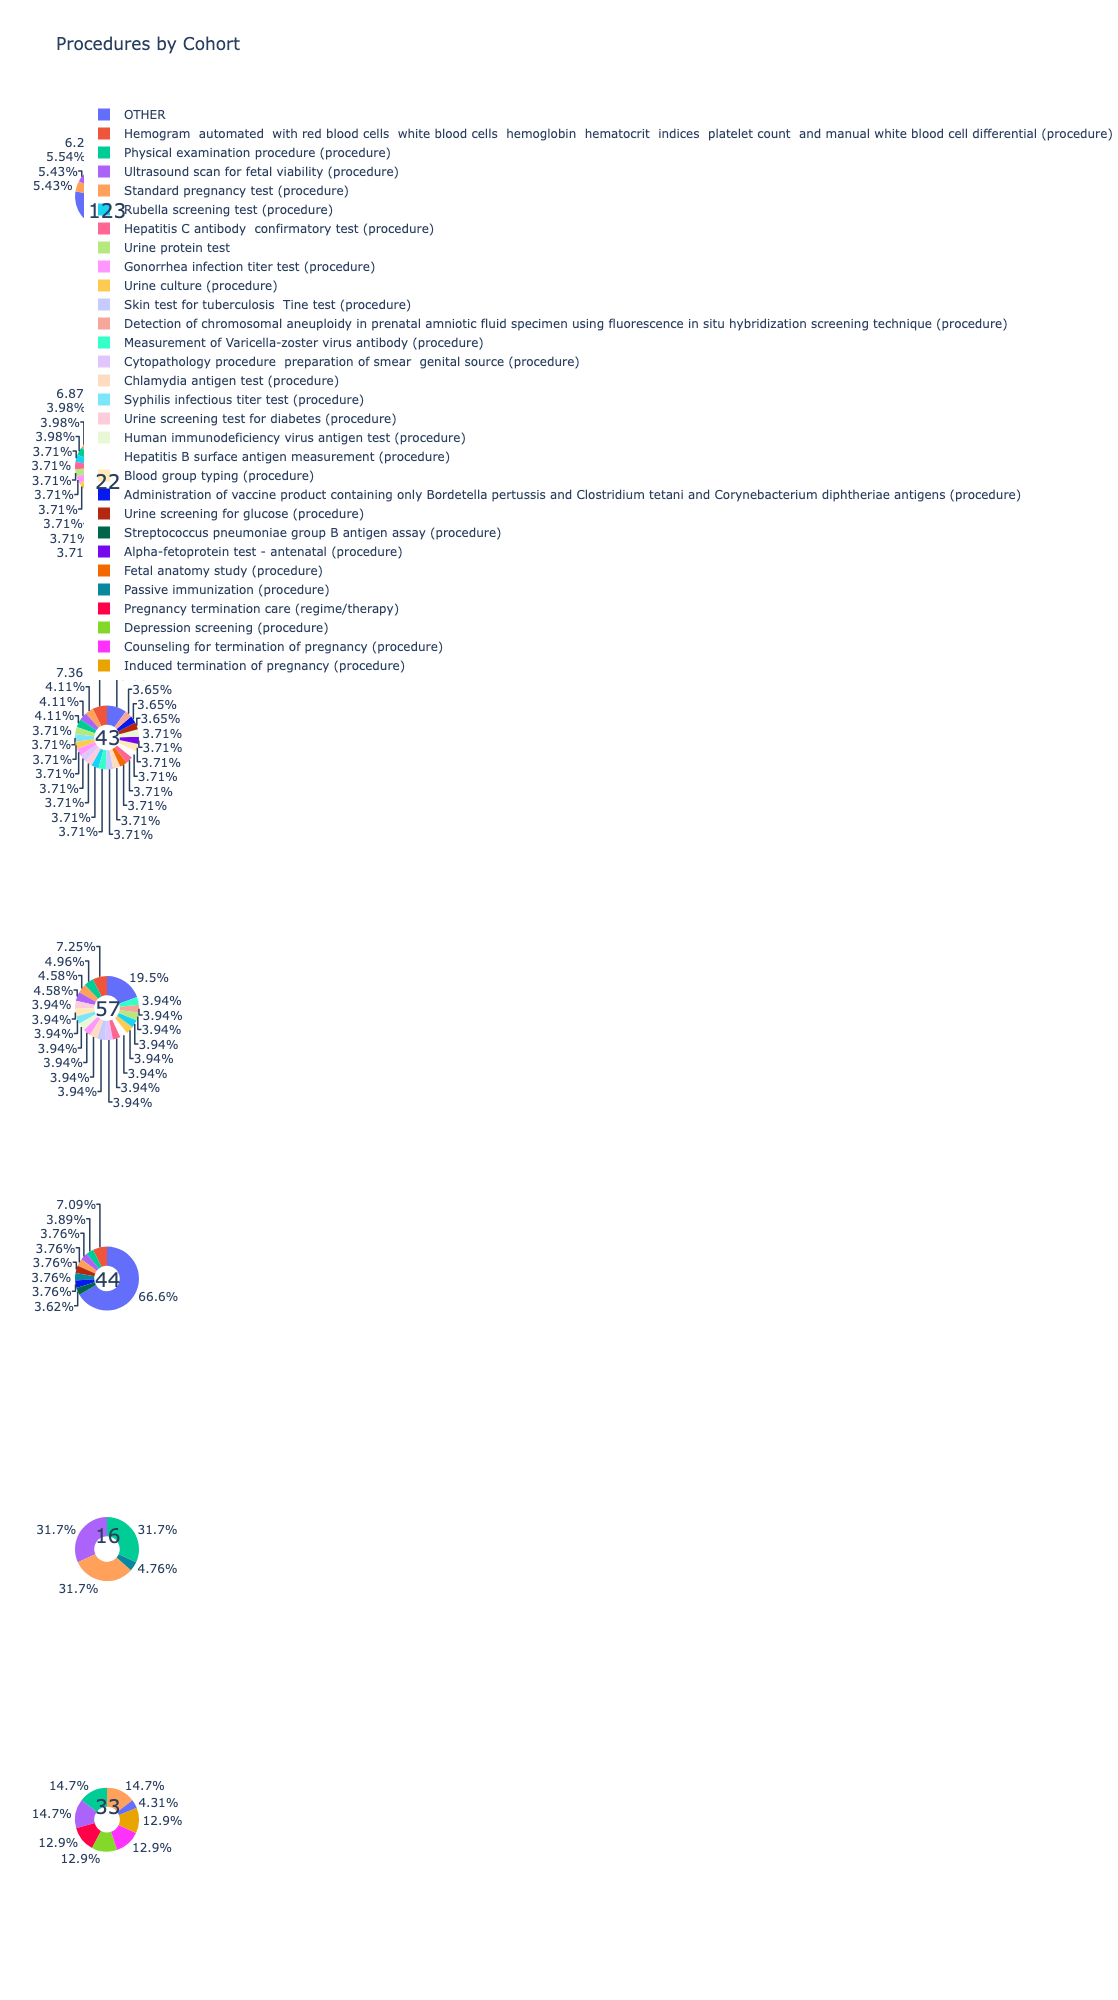

In [64]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

cohorts = proc_cohort_agg_df.COHORT.unique()
labels = proc_cohort_agg_df.DESCRIPTION.unique()

# Create subplots: use 'domain' type for Pie subplot

fig = make_subplots(rows=len(cohorts), cols=1, specs=[[{'type':'domain'}] for i in range(7)])
i = 0
annotations = []
for cohort in cohorts:
    i+=1
    df = proc_cohort_agg_df[proc_cohort_agg_df.COHORT == cohort]
    fig.add_trace(go.Pie(labels=df.DESCRIPTION, values=df.CNT, name=cohort), i, 1)
    annotations.append(dict(text=cohort, x=0.5, y=sum(fig.get_subplot(i, 1).y) / 2,
                      font_size=20, showarrow=False, xanchor="center"))
    


# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Procedures by Cohort", height=2000, width=2000, annotations=annotations)
fig.show()

## Patient Journey Sankey


In [8]:
# Some id mapping to format final sankey dataframe

proc_types_df = session.sql(f'''
    SELECT DISTINCT CODE, DESCRIPTION 
    FROM PATIENT_DB.PUBLIC.PROCEDURES;
''').to_pandas()
proc_types_df = proc_types_df.reset_index().rename(columns = {'index':'seq_id'})

proc_cohort_sankey_df = session.table(f'patient_db.public.procedure_cohort_sankey').to_pandas()
proc_cohort_sankey_df = (proc_cohort_sankey_df
.merge(proc_types_df[['seq_id', 'CODE']].rename(columns={'seq_id': "source_id"}),
       left_on = 'SOURCE_PROC', right_on= 'CODE').drop(columns='CODE')
.merge(proc_types_df[['seq_id', 'CODE']].rename(columns={'seq_id': "target_id"}),
        left_on = 'TARGET_PROC', right_on= 'CODE').drop(columns='CODE')
)
#proc_cohort_sankey_df = proc_cohort_sankey_df[proc_cohort_sankey_df.source_id != proc_cohort_sankey_df.target_id]
proc_cohort_sankey_df

,COHORT,SOURCE_PROC,TARGET_PROC,FREQ,PERCENT_FREQ,source_id,target_id
0,16,252160004,169230002,20,0.317460,0,1
1,16,169230002,5880005,17,0.269841,1,64
2,16,252160004,252160004,16,0.253968,0,0
3,16,5880005,252160004,4,0.063492,64,0
4,16,169230002,51116004,3,0.047619,1,18
...,...,...,...,...,...,...,...
1144,123,28163009,104375008,1,0.000283,30,12
1145,123,252160004,47758006,1,0.000283,0,6
1146,123,117010004,47758006,1,0.000283,11,6
1147,123,237001001,44608003,1,0.000283,19,4


In [13]:
import plotly.graph_objects as go

def make_sankey(cohort, min_value=0.01):
    fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 10,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = proc_types_df['DESCRIPTION'],
      color = "blue"
    ),
    link = dict(
      source = proc_cohort_sankey_df[(proc_cohort_sankey_df.PERCENT_FREQ>min_value) & (proc_cohort_sankey_df.COHORT==cohort)].source_id,
      target = proc_cohort_sankey_df[(proc_cohort_sankey_df.PERCENT_FREQ>min_value) & (proc_cohort_sankey_df.COHORT==cohort)].target_id,
      value = proc_cohort_sankey_df[(proc_cohort_sankey_df.PERCENT_FREQ>min_value) & (proc_cohort_sankey_df.COHORT==cohort)].FREQ
    ))])

    fig.update_layout(title_text=f"Cohort {cohort} Patient Journeys Sankey Diagram", 
            font_size=10, 
            height=700,
            width=1200
    )
    return fig 

In [14]:
proc_cohort_sankey_df.COHORT.value_counts()

COHORT
123    411
22     268
43     189
44     162
57      90
33      23
16       6
Name: count, dtype: int64

In [15]:
make_sankey(cohort=22)

In [17]:
make_sankey(cohort=33)